In [125]:
#import libraries
library(tidyverse)
library(dplyr)
library(psych)
library(ggplot2)
library(lattice)
library(caret)
library(e1071)

In [2]:
#import data
data <- read_csv("rain_data.csv")
head(data)

Parsed with column specification:
cols(
  .default = col_double(),
  Location = col_character(),
  WindGustDir = col_character(),
  WindDir9am = col_character(),
  WindDir3pm = col_character(),
  RainToday = col_character(),
  RainTomorrow = col_logical()
)
See spec(...) for full column specifications.


Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Hobart,6.3,9.8,2.2,WSW,52,WSW,WNW,13,15,60,47,1014.6,1014.0,4,1,7.2,9.5,Yes,TRUE
PearceRAAF,16.4,27.0,0.0,SW,46,SSW,SW,19,28,48,33,1007.5,1007.7,8,5,21.7,25.0,No,FALSE
Cairns,24.3,31.0,0.6,ENE,35,S,ESE,13,13,77,68,1010.2,1007.2,7,7,27.6,29.8,No,TRUE
Canberra,3.4,15.5,0.0,ENE,26,SE,WSW,9,6,68,60,1028.1,1024.1,7,8,12.2,14.6,No,FALSE
Watsonia,5.9,15.4,0.8,ENE,13,N,NW,2,6,99,49,1027.7,1024.9,2,3,7.8,15.2,No,FALSE
MountGambier,4.8,16.5,0.2,ENE,26,NE,ENE,7,15,91,51,1032.9,1029.6,2,7,8.0,16.5,No,FALSE


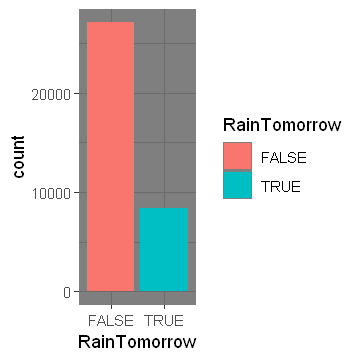

In [3]:
#check for bias
options(repr.plot.width=3, repr.plot.height=3)
ggplot(data, aes(RainTomorrow, fill=RainTomorrow)) + geom_bar() + theme_dark()

In [4]:
#convert to categorical
data$RainToday[data$RainToday=="No"] <- 0
data$RainToday[data$RainToday=="Yes"] <- 1
data$RainToday <- as.numeric(data$RainToday)
data$RainTomorrow[data$RainTomorrow=="False"] <- 0
data$RainTomorrow[data$RainTomorrow=="True"] <- 1

In [5]:
#check how many locations are there
table(data$Location)


          Albury     AliceSprings         Ballarat          Bendigo 
             397             1184              846              851 
        Brisbane           Cairns         Canberra            Cobar 
            1508             1325              806             1232 
    CoffsHarbour           Darwin           Hobart        Katherine 
             974             1557              978              335 
       Melbourne MelbourneAirport          Mildura            Moree 
             950             1466             1355             1085 
    MountGambier    NorfolkIsland        Nuriootpa       PearceRAAF 
            1371             1391             1033              701 
           Perth     PerthAirport         Portland         Richmond 
            1515             1459             1091              182 
            Sale           Sydney    SydneyAirport       Townsville 
            1157              863             1462             1296 
           Uluru       WaggaWagga

In [6]:
#group locations to reduce dimentionality
data$Location[data$Location=="Albury"] <- 'NSW'
data$Location[data$Location=="AliceSprings"] <- 'NT'
data$Location[data$Location=="Ballarat"] <- 'VIC'
data$Location[data$Location=="Bendigo"] <- 'VIC'

data$Location[data$Location=="Brisbane"] <- 'QLD'
data$Location[data$Location=="Cairns"] <- 'QLD'
data$Location[data$Location=="Canberra"] <- 'ACT'
data$Location[data$Location=="Cobar"] <- 'NSW'

data$Location[data$Location=="CoffsHarbour"] <- 'NSW'
data$Location[data$Location=="Darwin"] <- 'NT'
data$Location[data$Location=="Hobart"] <- 'TAS'
data$Location[data$Location=="Katherine"] <- 'NT'

data$Location[data$Location=="Melbourne"] <- 'VIC'
data$Location[data$Location=="MelbourneAirport"] <- 'VIC'
data$Location[data$Location=="Mildura"] <- 'VIC'
data$Location[data$Location=="Moree"] <- 'NSW'

data$Location[data$Location=="MountGambier"] <- 'SA'
data$Location[data$Location=="NorfolkIsland"] <- 'NorfolkIsland'
data$Location[data$Location=="Nuriootpa"] <- 'SA'
data$Location[data$Location=="PearceRAAF"] <- 'WA'

data$Location[data$Location=="Perth"] <- 'WA'
data$Location[data$Location=="PerthAirport"] <- 'WA'
data$Location[data$Location=="Portland"] <- 'VIC'
data$Location[data$Location=="Richmond"] <- 'VIC'

data$Location[data$Location=="Sale"] <- 'VIC'
data$Location[data$Location=="Sydney"] <- 'NSW'
data$Location[data$Location=="SydneyAirport"] <- 'NSW'
data$Location[data$Location=="Townsville"] <- 'QLD'

data$Location[data$Location=="Uluru"] <- 'NT'
data$Location[data$Location=="WaggaWagga"] <- 'NSW'
data$Location[data$Location=="Watsonia"] <- 'VIC'
data$Location[data$Location=="Williamtown"] <- 'VIC'
data$Location[data$Location=="Wollongong"] <- 'NSW'
data$Location[data$Location=="Woomera"] <- 'SA'

In [7]:
#check how many wind directions
table(data$WindGustDir)
table(data$WindDir9am)
table(data$WindDir3pm)


   E  ENE  ESE    N   NE  NNE  NNW   NW    S   SE  SSE  SSW   SW    W  WNW  WSW 
2761 2389 2086 2498 1964 1637 1473 1703 2387 2363 2106 2396 2586 2697 2009 2467 


   E  ENE  ESE    N   NE  NNE  NNW   NW    S   SE  SSE  SSW   SW    W  WNW  WSW 
2736 2328 2119 3129 2043 2045 1920 1819 2247 2534 2449 1958 2140 2226 1880 1949 


   E  ENE  ESE    N   NE  NNE  NNW   NW    S   SE  SSE  SSW   SW    W  WNW  WSW 
2316 2324 2276 2268 2064 1497 1759 1799 2635 2522 2137 2272 2596 2522 2072 2463 

In [8]:
#manually convert directions to dummy variables
#in order to reduce the dimentionality
#WinGustDir
data$WGD_EorW <- 0
data$WGD_EorW[data$WindGustDir=='E'] <- 1
data$WGD_EorW[data$WindGustDir=='W'] <- -1

data$WGD_ENEorWSW <- 0
data$WGD_ENEorWSW[data$WindGustDir=='ENE'] <- 1
data$WGD_ENEorWSW[data$WindGustDir=='WSW'] <- -1

data$WGD_ESEorWNW <- 0
data$WGD_ESEorWNW[data$WindGustDir=='ESE'] <- 1
data$WGD_ESEorWNW[data$WindGustDir=='WNW'] <- -1

data$WGD_NorS <- 0
data$WGD_NorS[data$WindGustDir=='N'] <- 1
data$WGD_NorS[data$WindGustDir=='S'] <- -1

data$WGD_NEorSW <- 0
data$WGD_NEorSW[data$WindGustDir=='NE'] <- 1
data$WGD_NEorSW[data$WindGustDir=='SW'] <- -1

data$WGD_NNEorSSW <- 0
data$WGD_NNEorSSW[data$WindGustDir=='NNE'] <- 1
data$WGD_NNEorSSW[data$WindGustDir=='SSW'] <- -1

data$WGD_NNWorSSE <- 0
data$WGD_NNWorSSE[data$WindGustDir=='NNW'] <- 1
data$WGD_NNWorSSE[data$WindGustDir=='SSE'] <- -1

data$WGD_NWorSE <- 0
data$WGD_NWorSE[data$WindGustDir=='NW'] <- 1
data$WGD_NWorSE[data$WindGustDir=='SE'] <- -1

In [9]:
#WindDir9am
data$WGD9_EorW <- 0
data$WGD9_EorW[data$WindDir9am=='E'] <- 1
data$WGD9_EorW[data$WindDir9am=='W'] <- -1

data$WGD9_ENEorWSW <- 0
data$WGD9_ENEorWSW[data$WindDir9am=='ENE'] <- 1
data$WGD9_ENEorWSW[data$WindDir9am=='WSW'] <- -1

data$WGD9_ESEorWNW <- 0
data$WGD9_ESEorWNW[data$WindDir9am=='ESE'] <- 1
data$WGD9_ESEorWNW[data$WindDir9am=='WNW'] <- -1

data$WGD9_NorS <- 0
data$WGD9_NorS[data$WindDir9am=='N'] <- 1
data$WGD9_NorS[data$WindDir9am=='S'] <- -1

data$WGD9_NEorSW <- 0
data$WGD9_NEorSW[data$WindDir9am=='NE'] <- 1
data$WGD9_NEorSW[data$WindDir9am=='SW'] <- -1

data$WGD9_NNEorSSW <- 0
data$WGD9_NNEorSSW[data$WindDir9am=='NNE'] <- 1
data$WGD9_NNEorSSW[data$WindDir9am=='SSW'] <- -1

data$WGD9_NNWorSSE <- 0
data$WGD9_NNWorSSE[data$WindDir9am=='NNW'] <- 1
data$WGD9_NNWorSSE[data$WindDir9am=='SSE'] <- -1

data$WGD9_NWorSE <- 0
data$WGD9_NWorSE[data$WindDir9am=='NW'] <- 1
data$WGD9_NWorSE[data$WindDir9am=='SE'] <- -1

In [10]:
#WindDir3pm
data$WGD3_EorW <- 0
data$WGD3_EorW[data$WindDir3pm=='E'] <- 1
data$WGD3_EorW[data$WindDir3pm=='W'] <- -1

data$WGD3_ENEorWSW <- 0
data$WGD3_ENEorWSW[data$WindDir3pm=='ENE'] <- 1
data$WGD3_ENEorWSW[data$WindDir3pm=='WSW'] <- -1

data$WGD3_ESEorWNW <- 0
data$WGD3_ESEorWNW[data$WindDir3pm=='ESE'] <- 1
data$WGD3_ESEorWNW[data$WindDir3pm=='WNW'] <- -1

data$WGD3_NorS <- 0
data$WGD3_NorS[data$WindDir3pm=='N'] <- 1
data$WGD3_NorS[data$WindDir3pm=='S'] <- -1

data$WGD3_NEorSW <- 0
data$WGD3_NEorSW[data$WindDir3pm=='NE'] <- 1
data$WGD3_NEorSW[data$WindDir3pm=='SW'] <- -1

data$WGD3_NNEorSSW <- 0
data$WGD3_NNEorSSW[data$WindDir3pm=='NNE'] <- 1
data$WGD3_NNEorSSW[data$WindDir3pm=='SSW'] <- -1

data$WGD3_NNWorSSE <- 0
data$WGD3_NNWorSSE[data$WindDir3pm=='NNW'] <- 1
data$WGD3_NNWorSSE[data$WindDir3pm=='SSE'] <- -1

data$WGD3_NWorSE <- 0
data$WGD3_NWorSE[data$WindDir3pm=='NW'] <- 1
data$WGD3_NWorSE[data$WindDir3pm=='SE'] <- -1

In [11]:
#change location type
data <- data[c(-5, -7, -8)] %>% mutate(Location=as.factor(Location))

In [12]:
#some skewness observed
describe(data)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
Location*,1,35522,5.688503e+00,2.3729345,6.0,5.7163066,2.96520,1.0,9.0,8.0,-0.12456375,-1.39136892,0.012590328
MinTemp,2,35522,1.319322e+01,6.4500788,13.0,13.1418362,7.26474,-6.7,31.4,38.1,0.06017654,-0.73911853,0.034222861
MaxTemp,3,35522,2.384466e+01,7.1457936,23.4,23.6820642,8.15430,4.6,48.1,43.5,0.20308065,-0.66801435,0.037914189
Rainfall,4,35522,2.713890e+00,9.8147803,0.0,0.6397565,0.00000,0.0,278.4,278.4,9.56870467,144.64990172,0.052075312
WindGustSpeed,5,35522,4.106900e+01,13.3887502,39.0,39.9895489,11.86080,9.0,124.0,115.0,0.94719971,1.55209731,0.071038100
WindSpeed9am,6,35522,1.579644e+01,8.3189411,15.0,15.0824829,8.89560,2.0,69.0,67.0,0.91424815,1.36921392,0.044138680
WindSpeed3pm,7,35522,1.979317e+01,8.5560358,19.0,19.3172637,8.89560,2.0,76.0,74.0,0.65305409,0.77863164,0.045396659
Humidity9am,8,35522,6.711421e+01,19.0930532,68.0,68.1427264,19.27380,1.0,100.0,99.0,-0.48792195,-0.01439096,0.101304020
Humidity3pm,9,35522,5.069546e+01,20.9206282,51.0,50.5833627,22.23900,0.0,100.0,100.0,0.01641149,-0.52997226,0.111000776
Pressure9am,10,35522,1.017162e+03,6.9865763,1017.1,1017.1680273,6.81996,982.2,1040.4,58.2,-0.07255388,0.25518760,0.037069413


In [13]:
#define function to plot distributions and boxplot
plot_box_hist <- function(dataframe, nrow, ncol){
    options(repr.plot.width=NULL, repr.plot.height=3)
    par(mfrow = c(nrow,ncol), mar=c(1,1,1,1))
    for (i in names(dataframe)) {
        boxplot(dataframe[[i]], main = i, cex.main=.7, type='l', col = 'orange')
    }
    
    par(mfrow = c(nrow,ncol), mar=c(2,1,1,1))
    for (i in names(dataframe)){
        hist(dataframe[[i]], main=i, cex.main=.5, col='cyan3')
    }
}

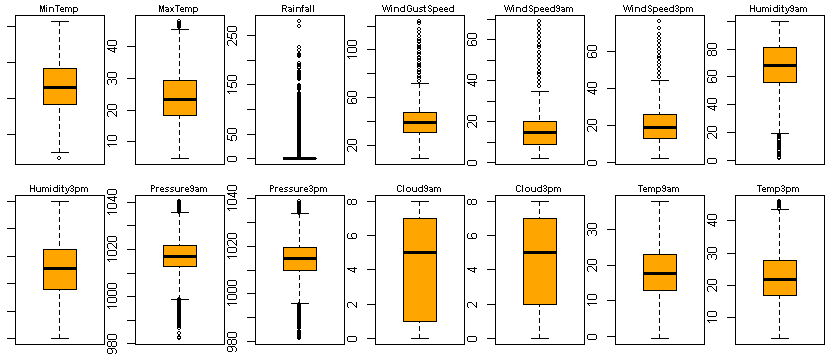

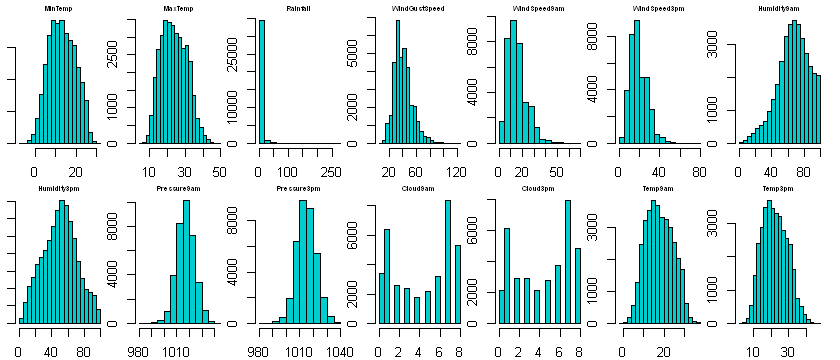

In [14]:
plot_box_hist(data[c(2:15)], 2, 7)

Some extreme values and non-normal distribution observed form above diagrams. Transformation will be considered.

In [15]:
#define function to re-scale variables
re_scale <- function(x){(x-min(x))/(max(x)-min(x))}

In [16]:
#rescale variables containing negative values so that they can be transformed.
data$MinTemp <- re_scale(data$MinTemp)
data$Temp9am <- re_scale(data$Temp9am)
head(data[c(2, 17)])

MinTemp,RainTomorrow
0.3412073,1
0.6062992,0
0.8136483,1
0.2650919,0
0.3307087,0
0.3018373,0


In [17]:
#define function for transformation
transformation <- function(dataframe, attribute){
    col_index <- which(colnames(dataframe)==attribute)
    hist(dataframe[[col_index]], main=attribute, col='mediumpurple1')
    hist(log(dataframe[[col_index]]+1), main=paste0('log(',attribute,')'), col='khaki2')
    hist(sqrt(dataframe[[col_index]]), main=paste0('sqrt(',attribute,')'), col='plum1')
    }

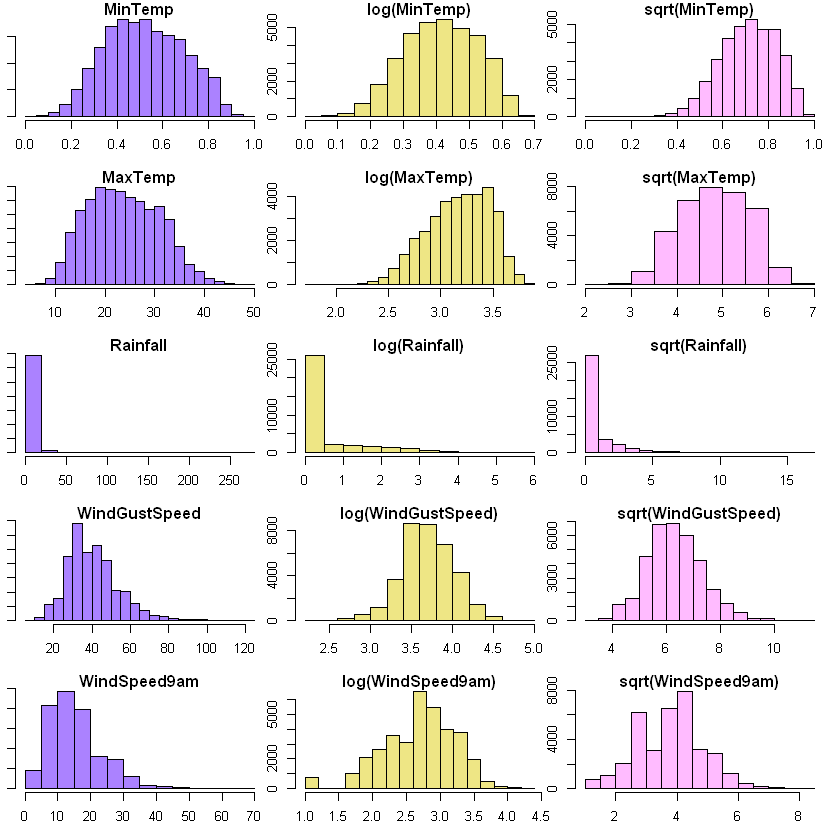

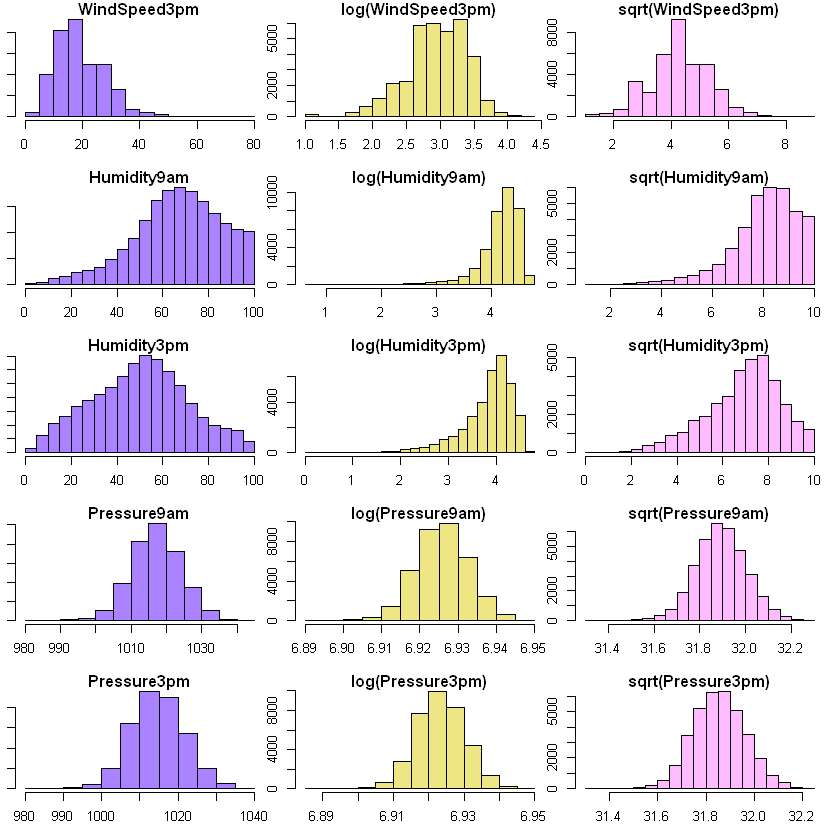

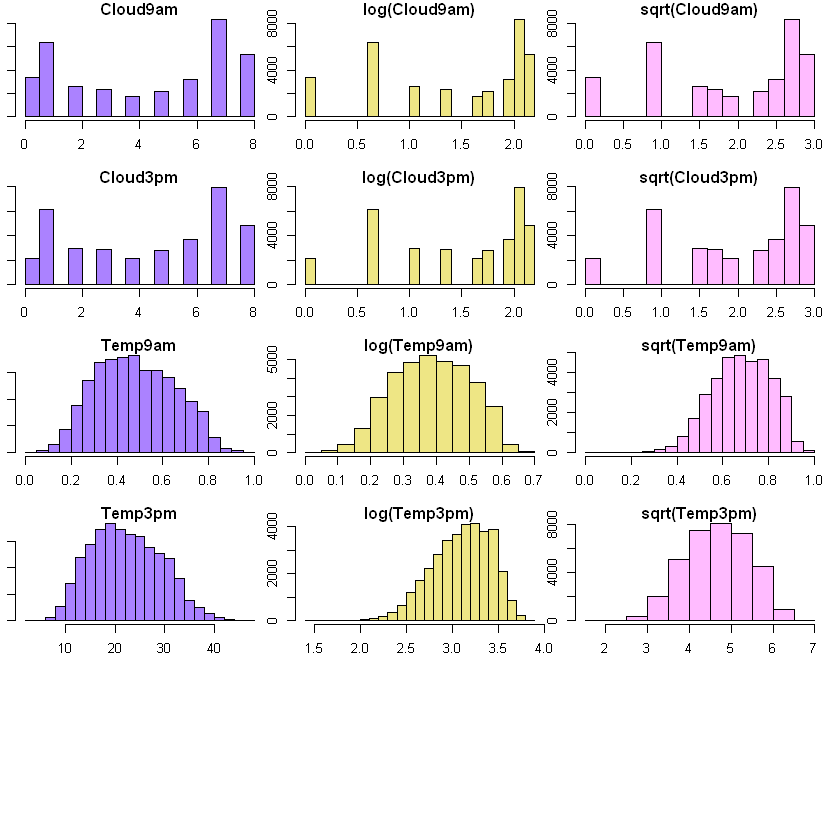

In [18]:
#transform continuous variables
options(repr.plot.width=NULL, repr.plot.height=NULL)
par(mfrow = c(5,3), mar=c(3,1,1,1))
for (name in names(data[c(2:15)])){
    transformation(data[c(2:15)], name)
}

In [19]:
#create master dataframe to store transformations
transformed_data <- data %>% mutate(sqrt_MaxTemp=sqrt(MaxTemp),
                                   log_WindGustSpeed=log(WindGustSpeed+1),
                                   log_WindSpeed9am=log(WindSpeed9am+1),
                                   sqrt_WindSpeed3am=sqrt(WindSpeed3pm),
                                   log_Temp9am=log(Temp9am+1))

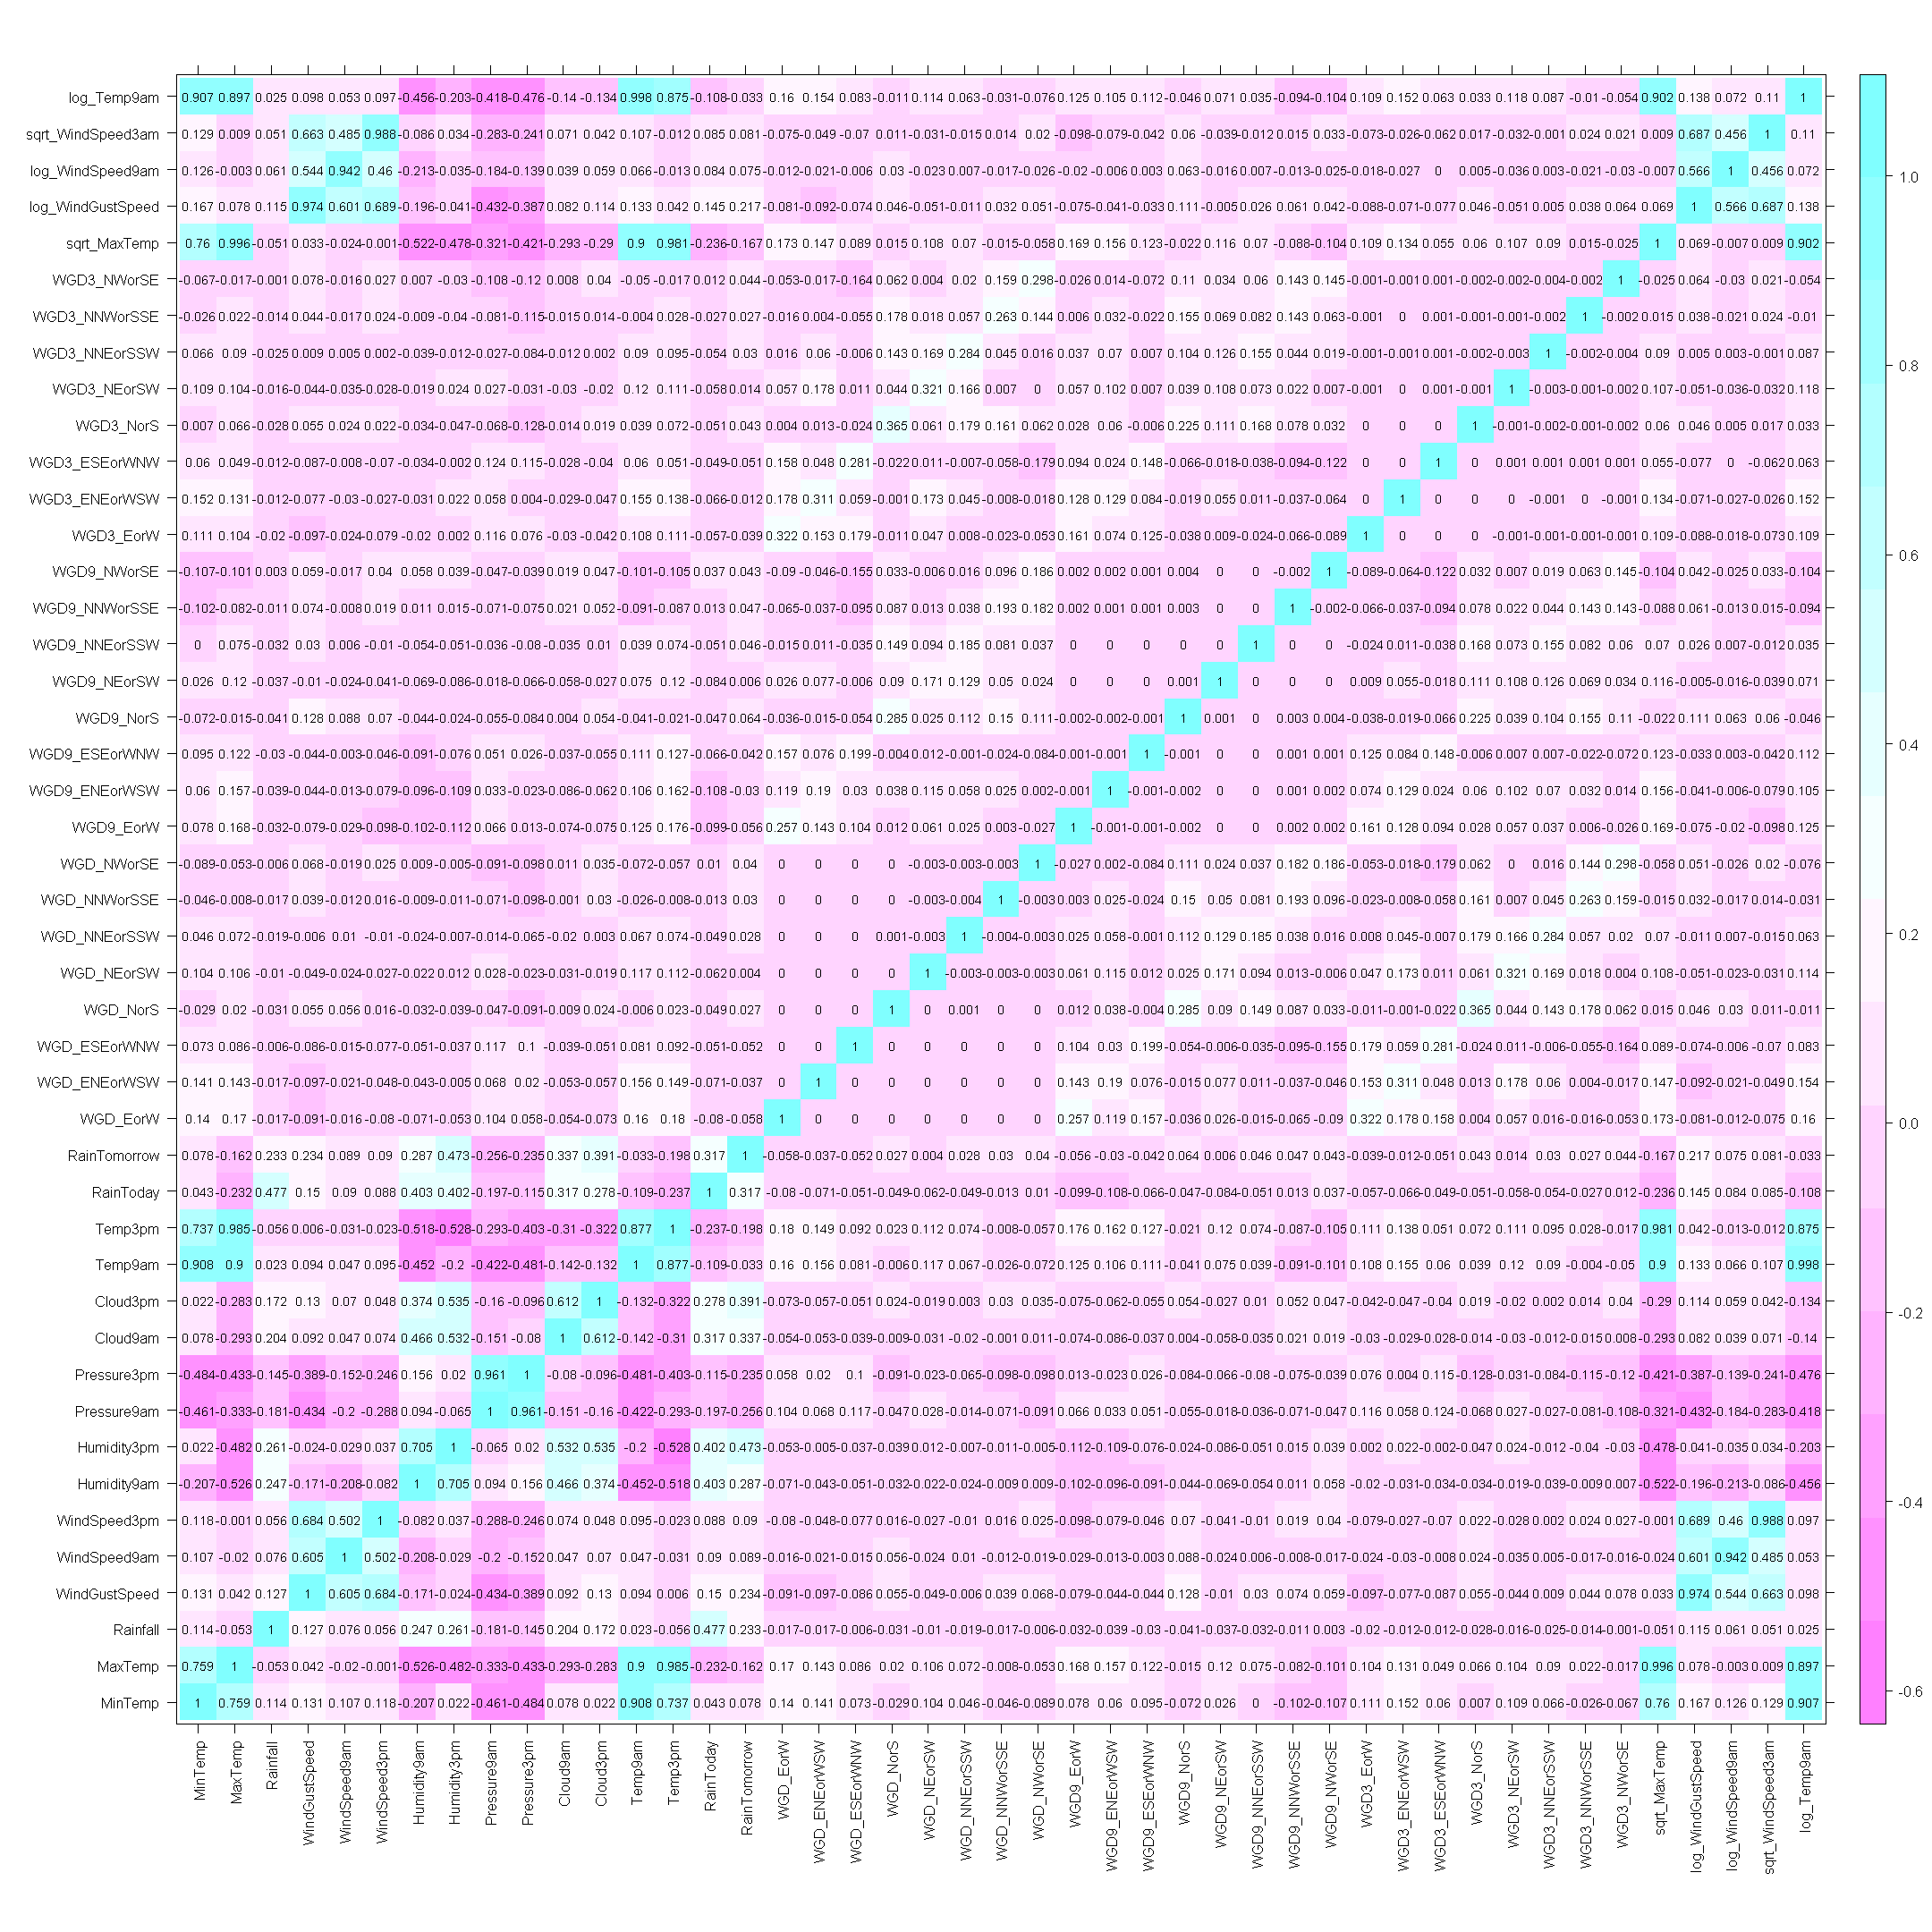

In [20]:
#plot the correlation heatmap
options(repr.plot.width=18, repr.plot.height=18)
myPanel <- function(x, y, z, ...) {
    panel.levelplot(x,y,z,...)
    panel.text(x, y, round(z, 3), cex=.7)
}
levelplot(cor(transformed_data[-1]), xlab = NULL, ylab = NULL, 
          scales = list(x = list(rot = 90)), panel = myPanel)

Observed that there is no significant improvement on the correlation even after transformation.

In [113]:
#randomly split the data
#70% for training
set.seed(123)
split <- sample(1:nrow(transformed_data), 0.7*nrow(transformed_data)) #split into 30% for test
train <- transformed_data[split,]
test  <- transformed_data[-split,]

In [114]:
#model 1 train all variables
model1 <- glm(RainTomorrow~., family='binomial', data=train)
summary(model1)


Call:
glm(formula = RainTomorrow ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4857  -0.5354  -0.2778  -0.0888   3.1524  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)            5.278e+01  4.076e+00  12.950  < 2e-16 ***
LocationNorfolkIsland -3.757e-01  1.670e-01  -2.250 0.024427 *  
LocationNSW            1.009e-01  1.420e-01   0.711 0.477239    
LocationNT            -1.831e-01  1.666e-01  -1.099 0.271943    
LocationQLD            4.430e-02  1.574e-01   0.282 0.778301    
LocationSA             9.070e-02  1.496e-01   0.606 0.544326    
LocationTAS           -4.882e-01  1.782e-01  -2.739 0.006154 ** 
LocationVIC           -7.946e-02  1.380e-01  -0.576 0.564745    
LocationWA             6.333e-01  1.499e-01   4.226 2.38e-05 ***
MinTemp                6.058e-01  4.248e-01   1.426 0.153870    
MaxTemp                1.761e-01  5.727e-02   3.075 0.002108 ** 
Rainfall         

In [115]:
#compute the model performance.
probs <- predict(model1, test, type = "response")
prediction <- rep("0", length(probs))
prediction[probs > 0.5] <- "1"
confusionMatrix(table(prediction, test$RainTomorrow), positive = "1")

Confusion Matrix and Statistics

          
prediction    0    1
         0 7600 1089
         1  498 1470
                                          
               Accuracy : 0.8511          
                 95% CI : (0.8442, 0.8578)
    No Information Rate : 0.7599          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5569          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.5744          
            Specificity : 0.9385          
         Pos Pred Value : 0.7470          
         Neg Pred Value : 0.8747          
             Prevalence : 0.2401          
         Detection Rate : 0.1379          
   Detection Prevalence : 0.1847          
      Balanced Accuracy : 0.7565          
                                          
       'Positive' Class : 1               
                                 

In [30]:
#perform anova test to check what variables is statistically significant
anova_test <- anova(model1, test="Chisq")

In [116]:
#filter the dataframe to just include important variables
p_values <- data.frame(anova_test[5])
p_values$name <- row.names(p_values)
p_values <- p_values[2:nrow(p_values),]
predictors <- as.vector(filter(p_values, p_values[1]<0.05)[[2]])

idx <- match(predictors, names(transformed_data))
idx <- sort(c(idx-1, idx))

new_data <- transformed_data[,colnames(transformed_data) %in% predictors]  
new_data$RainTomorrow <- transformed_data$RainTomorrow

In [117]:
#randomly split the data
#70% for training
set.seed(123)
split <- sample(1:nrow(new_data), 0.7*nrow(transformed_data)) #split into 30% for test
train <- new_data[split,]
test  <- new_data[-split,]

In [118]:
#model2 using new sets of predictors.
model2 <- glm(RainTomorrow~., family='binomial', data=train)
summary(model2)


Call:
glm(formula = RainTomorrow ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4815  -0.5363  -0.2785  -0.0906   3.1201  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           52.158470   3.705521  14.076  < 2e-16 ***
LocationNorfolkIsland -0.404408   0.164741  -2.455  0.01410 *  
LocationNSW            0.125570   0.139476   0.900  0.36796    
LocationNT            -0.271322   0.160656  -1.689  0.09125 .  
LocationQLD           -0.038765   0.152186  -0.255  0.79894    
LocationSA             0.119334   0.147043   0.812  0.41704    
LocationTAS           -0.493243   0.174680  -2.824  0.00475 ** 
LocationVIC           -0.054456   0.135411  -0.402  0.68757    
LocationWA             0.624265   0.146466   4.262 2.02e-05 ***
MinTemp                0.408516   0.415317   0.984  0.32530    
MaxTemp               -0.031921   0.011134  -2.867  0.00414 ** 
Rainfall               0.0035

In [119]:
#compute confusion matrix for model2
probs <- predict(model2, test, type = "response")
prediction <- rep("0", length(probs))
prediction[probs > 0.5] <- "1"
confusionMatrix(table(prediction, test$RainTomorrow), positive = "1")

Confusion Matrix and Statistics

          
prediction    0    1
         0 7596 1094
         1  502 1465
                                         
               Accuracy : 0.8502         
                 95% CI : (0.8433, 0.857)
    No Information Rate : 0.7599         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.5544         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.5725         
            Specificity : 0.9380         
         Pos Pred Value : 0.7448         
         Neg Pred Value : 0.8741         
             Prevalence : 0.2401         
         Detection Rate : 0.1375         
   Detection Prevalence : 0.1846         
      Balanced Accuracy : 0.7552         
                                         
       'Positive' Class : 1              
                                         

Observed that there is no much difference in performance between model1 and model2. The 85% accuracy may look promising. However, given that there is significant bias in this dataset and the model sensitivity is just 57%. Resampling will be considered to develop a more sensitive model to predict the rainy day.